In [1]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

In [4]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet arviz bambi preliz)"

In [2]:
%load_ext autoreload
%autoreload 2

import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

print("pymc.version=", pm.__version__)
print("arviz.version=", az.__version__)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc.version= 5.16.2
arviz.version= 0.19.0


In [6]:
import bambi as bmb
import preliz as pz

In [3]:
plt.rcParams['figure.figsize'] = [8, 3]

dir_name = "/aux/code/book.2018.Martin.Bayesian_Analysis_with_Python.2e"

# Posterior grid

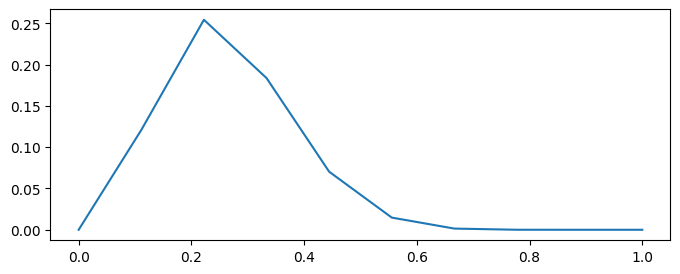

In [26]:
# Plot the model likelihood (in this case we assume we know the parameters).
heads = 3
tails = 10
grid_points = 10
#grid_points = 20
grid = np.linspace(0, 1, grid_points)
likelihood = pz.Binomial(n = heads + tails, p = grid).pdf(heads)
#print(likelihood)
plt.plot(grid, likelihood)

In [32]:
def posterior_grid(grid_points, heads, tails):
    # The interval for the parameter is [0, 1].
    grid = np.linspace(0, 1, grid_points)
    # The prior is uniform.
    prior = np.repeat(1 / grid_points, grid_points)
    # Likelihood is Binomial with known params.
    likelihood = pz.Binomial(n = heads + tails, p = grid).pdf(heads)
    # Compute the integral of the PDF.
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior

h= 3
t= 10


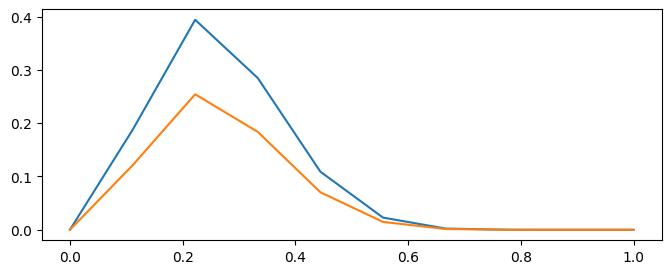

In [34]:
# Data.
# h = 10
# t = 3
h = 3
t = 10
print("h=", h)
print("t=", t)

grid, posterior = posterior_grid(grid_points, h, t)

# Plot posterior.
plt.plot(grid, posterior)
plt.plot(grid, likelihood)

# Diagnosis the templates

In [40]:
# Centered model.
with pm.Model() as model_c:
    # Param for the std dev of all Gaussians.
    a = pm.HalfNormal('a', 10)
    # 10 normals with mean=0 and std dev=a.
    b = pm.Normal('b', 0, a, shape=10)
    idata_c = pm.sample(random_seed=73)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [48]:
# Non-centered (re-parametrized) model.
with pm.Model() as model_nc:
    a = pm.HalfNormal('a', 10)
    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=10)
    # Gaussians are rescaled.
    b = pm.Deterministic('b', 0 + b_offset * a)
    #idata_nc = pm.sample(random_seed=73, target_accept=0.9)
    idata_nc = pm.sample(random_seed=73)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


## Visual check

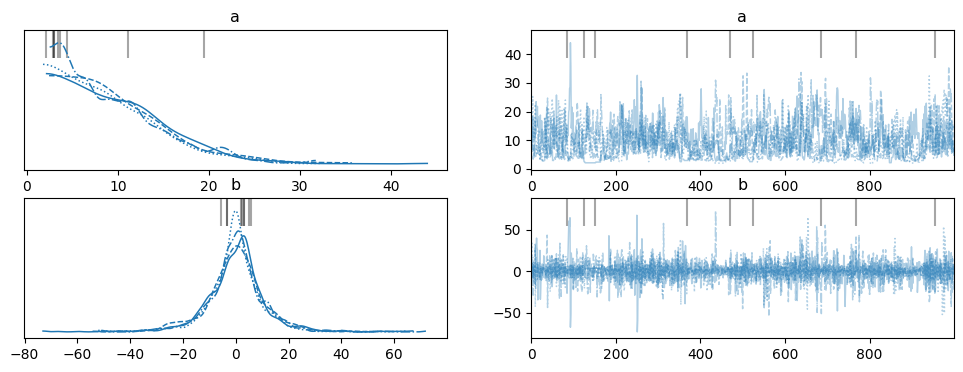

In [45]:
coords={'b_dim_0': [0]}
az.plot_trace(idata_c, var_names=['a', "b"], coords=coords, divergences='top');

- The trace in a shows some values stuck
- The 4 Gaussians for b don't look the same
- There are divergences reported on top

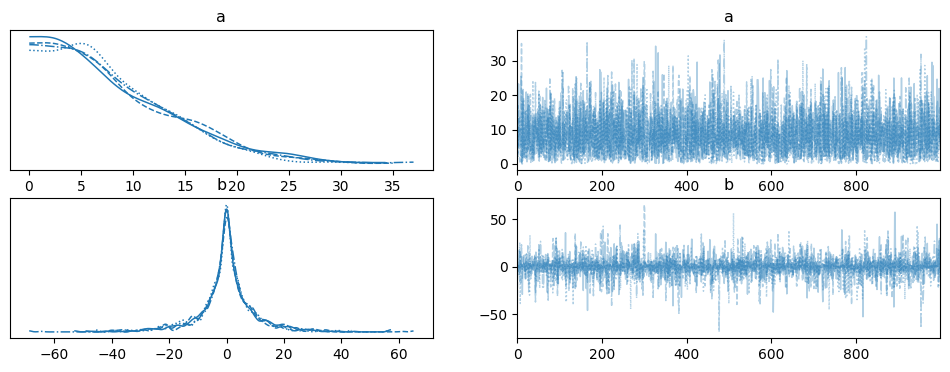

In [49]:
ax = az.plot_trace(idata_nc, var_names=['a', "b"], coords=coords, divergences='top')

## Rank plot

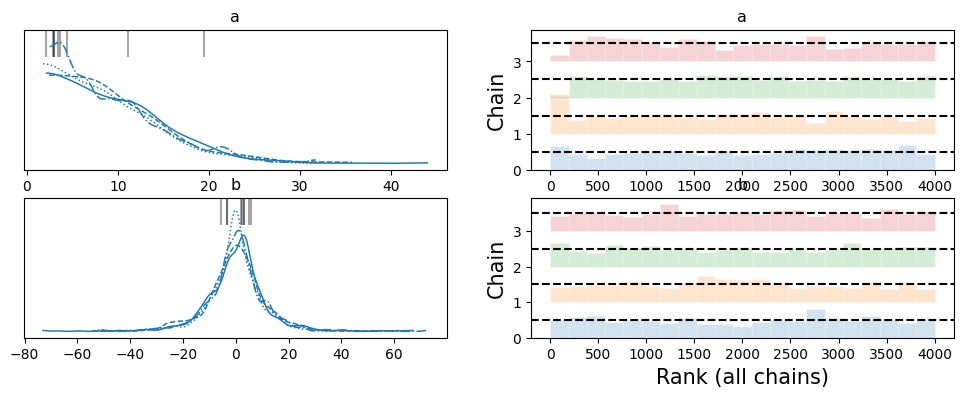

In [52]:
az.plot_trace(idata_c, var_names=['a', "b"], divergences='top', kind='rank_bars', coords=coords);

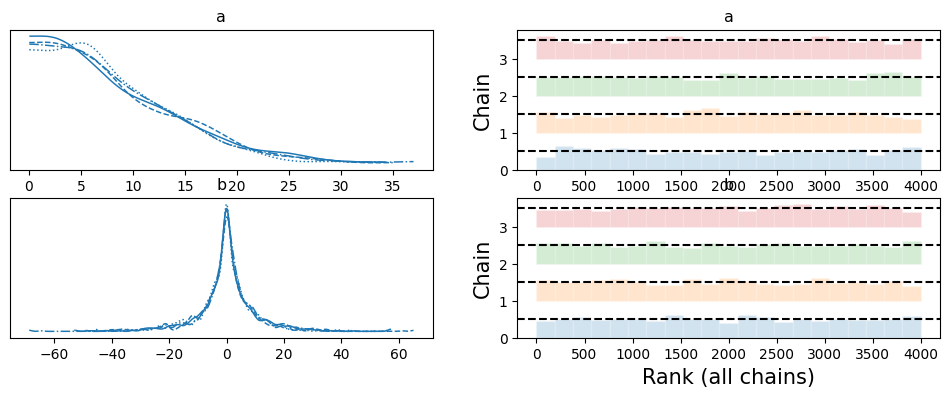

In [51]:
az.plot_trace(idata_nc, var_names=['a', "b"], divergences='top', kind='rank_bars', coords=coords);

## R hat

In [69]:
az.rhat(idata_c, var_names="a b".split()).to_dataframe().T

b_dim_0,0,1,2,3,4,5,6,7,8,9
a,1.011778,1.011778,1.011778,1.011778,1.011778,1.011778,1.011778,1.011778,1.011778,1.011778
b,1.003961,1.001272,1.003105,1.005235,1.005769,1.007143,1.008345,1.005189,1.006037,1.004922


- Rhat values for a is larger than 1.01

In [70]:
az.rhat(idata_nc, var_names="a b".split()).to_dataframe().T

b_dim_0,0,1,2,3,4,5,6,7,8,9
a,1.001687,1.001687,1.001687,1.001687,1.001687,1.001687,1.001687,1.001687,1.001687,1.001687
b,0.999673,1.000569,1.000212,0.999855,0.999957,1.000250,1.000105,1.000245,1.000752,0.999797


## ESS

In [71]:
az.ess(idata_c, var_names="a b".split()).to_dataframe().T

b_dim_0,0,1,2,3,4,5,6,7,8,9
a,222.564080,222.564080,222.564080,222.564080,222.564080,222.564080,222.564080,222.564080,222.564080,222.564080
b,4883.856915,4892.247391,5110.486787,6107.796795,4616.443057,4285.058733,5851.589974,5718.748575,5428.641706,4279.670784


In [72]:
az.ess(idata_nc, var_names="a b".split()).to_dataframe().T

b_dim_0,0,1,2,3,4,5,6,7,8,9
a,3545.924221,3545.924221,3545.924221,3545.924221,3545.924221,3545.924221,3545.924221,3545.924221,3545.924221,3545.924221
b,5551.845262,4800.106757,4619.049003,5393.659072,5252.179915,4847.159710,5236.258072,4543.189551,5068.281097,5236.289979


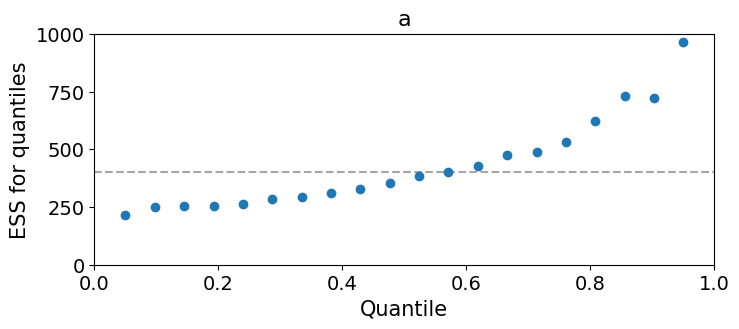

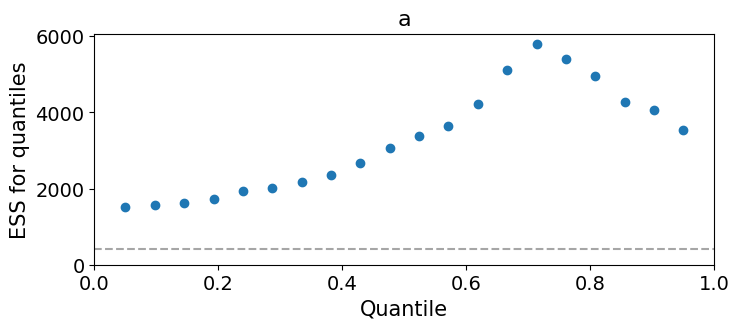

In [78]:
# Plot the ESS by quantile.
az.plot_ess(idata_cm, var_names="a", kind="quantile")
az.plot_ess(idata_ncm, var_names="a", kind="quantile");

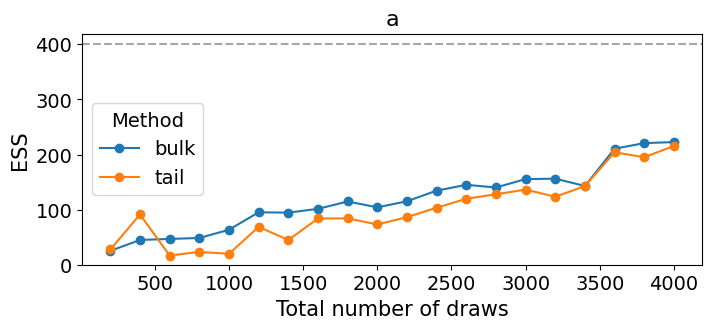

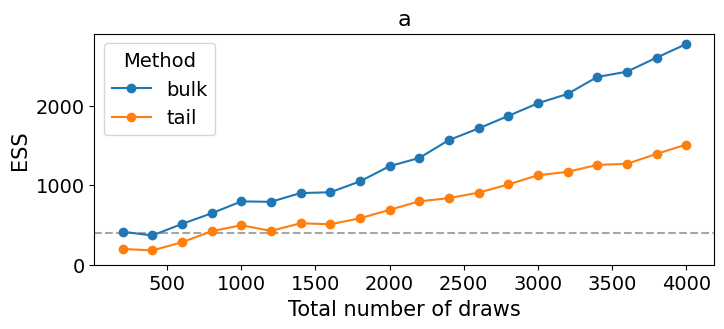

In [77]:
az.plot_ess(idata_cm, var_names="a", kind="evolution")
az.plot_ess(idata_ncm, var_names="a", kind="evolution");